In [ ]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

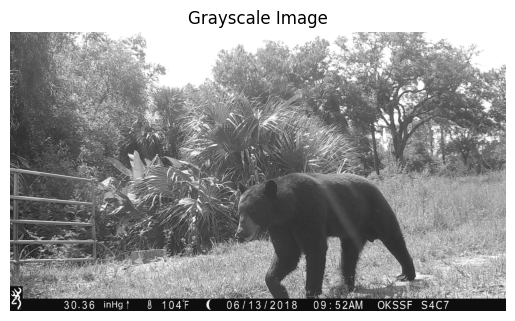

In [ ]:
# Load  image
img = cv2.imread('bears.JPG')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()


In [ ]:
# Define functions for salience computation
def compute_temporal_salience(frame, background_model):
    """Computes temporal salience by comparing the frame to the background model."""
    diff = cv2.absdiff(frame, background_model)
    amplified_diff = cv2.normalize(diff, None, 0, 255, cv2.NORM_MINMAX)  # Amplify differences
    return amplified_diff

def compute_spatial_salience(frame, kernel_size=3):
    """Computes spatial salience using Gaussian blur and amplifies differences."""
    blurred = cv2.GaussianBlur(frame, (kernel_size, kernel_size), 0)
    salience = cv2.absdiff(frame, blurred)
    amplified_salience = cv2.normalize(salience, None, 0, 255, cv2.NORM_MINMAX)  # Amplify differences
    return amplified_salience

(-0.5, 1919.5, 1079.5, -0.5)

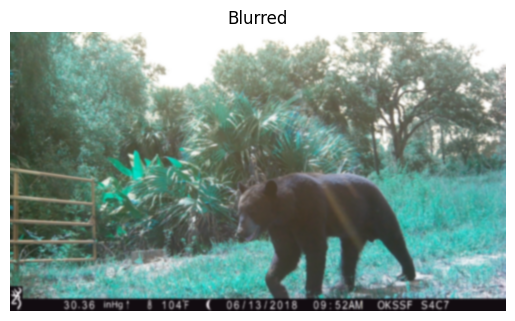

In [ ]:
background_model = cv2.GaussianBlur(img, (21,21), 0)

# Plot the Gaussian-blurred image
plt.imshow(background_model, cmap='gray')  # Also grayscale
plt.title(f"Blurred")
plt.axis('off')

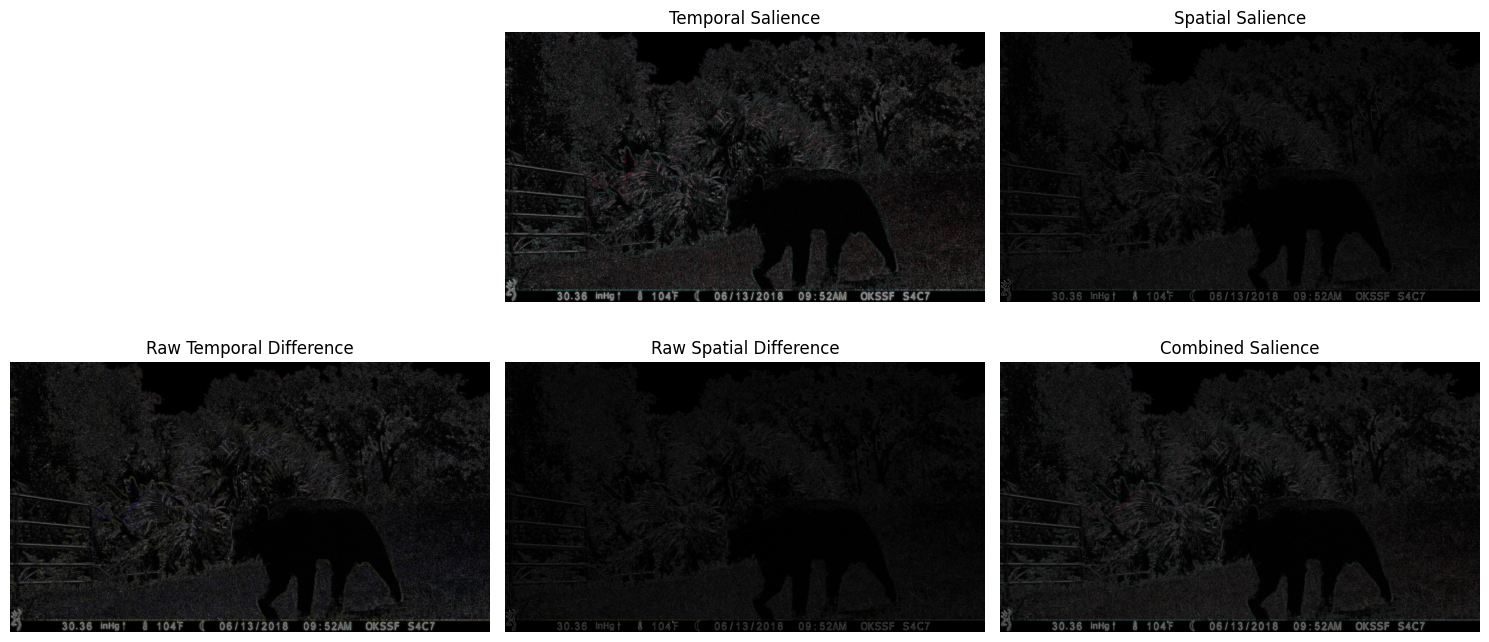

In [ ]:
# Compute Temporal and Spatial Salience
temporal_salience = compute_temporal_salience(img, background_model)
spatial_salience = compute_spatial_salience(img)


# Plot salience maped Images
plt.figure(figsize=(15, 10))

# Temporal Salience
plt.subplot(3, 3, 5)
plt.imshow(temporal_salience, cmap='gray')
plt.title("Temporal Salience")
plt.axis('off')

# Spatial Salience
plt.subplot(3, 3, 6)
plt.imshow(spatial_salience, cmap='gray')
plt.title("Spatial Salience")
plt.axis('off')

# Debugging: Show raw differences
raw_temporal_diff = cv2.absdiff(img, background_model)
plt.subplot(3, 3, 7)
plt.imshow(cv2.cvtColor(raw_temporal_diff, cv2.COLOR_BGR2RGB))
plt.title("Raw Temporal Difference")
plt.axis('off')

raw_spatial_diff = cv2.absdiff(img, cv2.GaussianBlur(img, (5, 5), 0))
plt.subplot(3, 3, 8)
plt.imshow(cv2.cvtColor(raw_spatial_diff, cv2.COLOR_BGR2RGB))
plt.title("Raw Spatial Difference")
plt.axis('off')

# Combined
plt.subplot(3, 3, 9)
plt.imshow(cv2.addWeighted(temporal_salience, 0.5, spatial_salience, 0.5, 0), cmap='gray')
plt.title("Combined Salience")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def compute_foreground_probability(fg_mask, beta=2.0):


    fg_mask = fg_mask.astype(np.uint8)  # Convert to uint8
    if len(fg_mask.shape) > 2:
        fg_mask = cv2.cvtColor(fg_mask, cv2.COLOR_BGR2GRAY)  # Convert to single-channel

    # Compute the distance transform
    dist_transform = cv2.distanceTransform(fg_mask, cv2.DIST_L2, 5)

    # Define s (1 for foreground, -1 for background)
    s = np.where(fg_mask > 0, 1, -1)

    # Compute probability
    prob_map = 0.5 + (1 / np.pi) * np.arctan(beta * s * dist_transform)

    # Debug: Check the range of prob_map
    print(f"Probability map range: min={prob_map.min()}, max={prob_map.max()}")

    # Normalize to range [0, 255] for visualization, if needed
    prob_map_normalized = cv2.normalize(prob_map, None, 0, 255, cv2.NORM_MINMAX)
    print(f"Normalized map range: min={prob_map_normalized.min()}, max={prob_map_normalized.max()}")

    return prob_map


In [ ]:
#new
def iterative_graph_cut(img_gray, fg_mask, alpha_values=[0.1, 0.3, 0.5, 0.7, 0.9]):

    proposals = []

    fg_mask = cv2.threshold(fg_mask, 70, 255, cv2.THRESH_BINARY)[1]
    fg_mask = fg_mask.astype(np.uint8)

    for alpha in alpha_values:
        # Compute the foreground probability map
        prob_map = compute_foreground_probability(fg_mask)

        # Normalize and visualize the probability map
        mask = cv2.normalize(prob_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Dynamic thresholding
        threshold_value = np.mean(prob_map) * 255  # Adaptive threshold
        _, fg_mask_refined = cv2.threshold(mask, threshold_value, 255, cv2.THRESH_BINARY)

        proposals.append(fg_mask_refined)

    return proposals

Probability map range: min=0.5, max=0.9995552986067979
Normalized map range: min=0.0, max=254.99999999999997
Probability map range: min=0.5, max=0.9995552986067979
Normalized map range: min=0.0, max=254.99999999999997
Probability map range: min=0.5, max=0.9995552986067979
Normalized map range: min=0.0, max=254.99999999999997
Probability map range: min=0.5, max=0.9995552986067979
Normalized map range: min=0.0, max=254.99999999999997
Probability map range: min=0.5, max=0.9995552986067979
Normalized map range: min=0.0, max=254.99999999999997


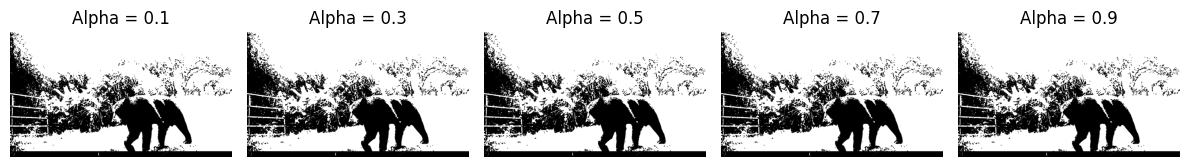

In [ ]:

_, fg_mask = cv2.threshold(img_gray, 70, 255, cv2.THRESH_BINARY)

alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Perform iterative graph cut refinement
segmentation_results = iterative_graph_cut(img_gray, fg_mask, alpha_values=alpha_values)


plt.figure(figsize=(12, 6))
for i, result in enumerate(segmentation_results):
    plt.subplot(1, len(segmentation_results), i + 1)
    plt.imshow(result, cmap='gray')
    plt.title(f"Alpha = {alpha_values[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


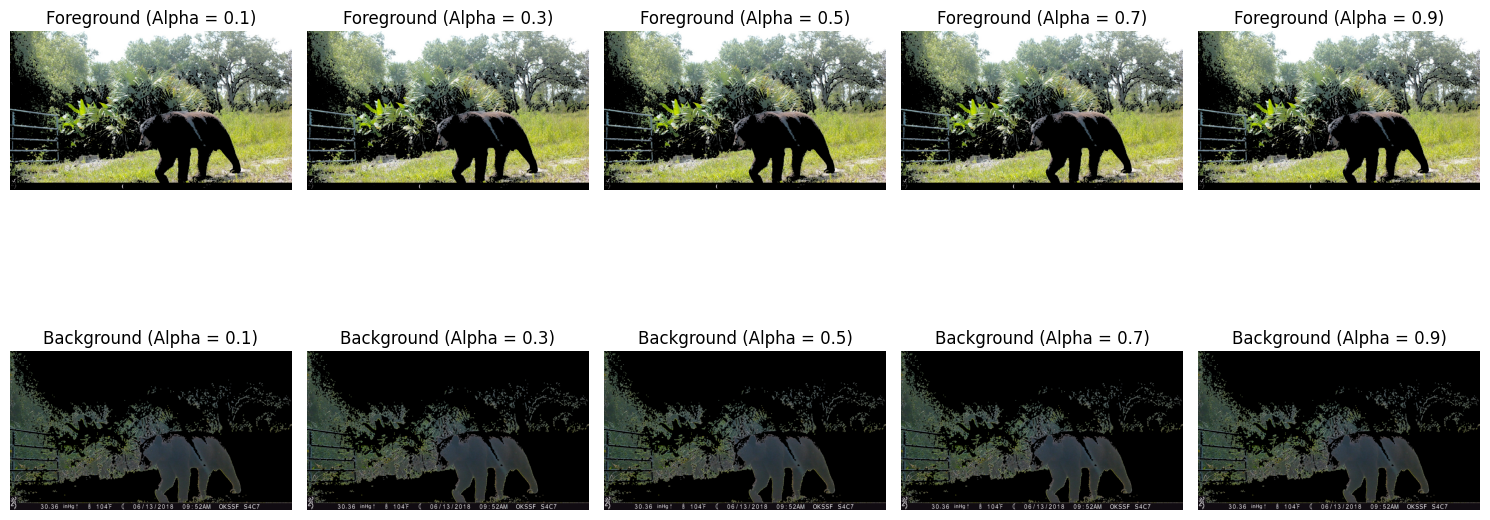

In [ ]:
def segment_foreground_background(img_gray, mask):


    mask = cv2.threshold(mask, 120, 255, cv2.THRESH_BINARY)[1]

    mask_inv = cv2.bitwise_not(mask)

    # Extract foreground and background
    foreground = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    background = cv2.bitwise_and(img_gray, img_gray, mask=mask_inv)

    return foreground, background


plt.figure(figsize=(15, 8))
for i, result in enumerate(segmentation_results):
    # Segment foreground and background
    foreground, background = segment_foreground_background(img, result)

    # Plot foreground
    plt.subplot(2, len(segmentation_results), i + 1)
    plt.imshow(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))
    plt.title(f"Foreground (Alpha = {alpha_values[i]})")
    plt.axis('off')

    # Plot background
    plt.subplot(2, len(segmentation_results), len(segmentation_results) + i + 1)
    plt.imshow(cv2.cvtColor(background, cv2.COLOR_BGR2RGB))
    plt.title(f"Background (Alpha = {alpha_values[i]})")
    plt.axis('off')

plt.tight_layout()
plt.show()


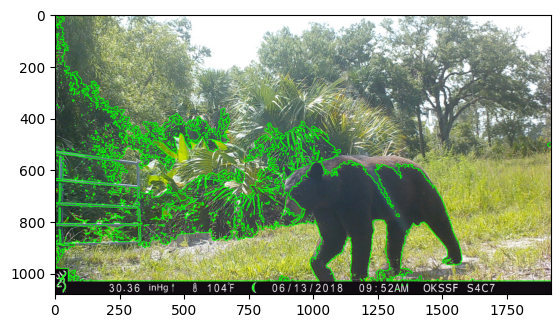

In [ ]:
contours, _ = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_overlay = img.copy()
cv2.drawContours(img_overlay, contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_overlay, cv2.COLOR_BGR2RGB))


In [ ]:
def compute_foreground_mask(img):

    #Computes a binary foreground mask using simple thresholding.
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, fg_mask = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY)
    return fg_mask

def extract_candidate_bounding_boxes(fg_mask):

    # Extracts bounding boxes of connected components in the foreground mask.

    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    return bounding_boxes

Streaming output truncated to the last 5000 lines.
Image bears.JPG, BBox (1894, 612, 3, 3), Score: -0.06, Classification: Animal
Image bears.JPG, BBox (1838, 612, 1, 3), Score: 0.30, Classification: Background
Image bears.JPG, BBox (1821, 612, 1, 1), Score: -0.39, Classification: Animal
Image bears.JPG, BBox (1796, 612, 3, 1), Score: 0.38, Classification: Background
Image bears.JPG, BBox (1787, 612, 1, 1), Score: 0.25, Classification: Background
Image bears.JPG, BBox (1758, 612, 5, 3), Score: 0.40, Classification: Background
Image bears.JPG, BBox (1636, 612, 9, 8), Score: -0.01, Classification: Animal
Image bears.JPG, BBox (1503, 612, 4, 2), Score: 0.28, Classification: Background
Image bears.JPG, BBox (1487, 612, 2, 1), Score: -0.04, Classification: Animal
Image bears.JPG, BBox (1479, 612, 4, 2), Score: 0.16, Classification: Background
Image bears.JPG, BBox (1459, 612, 2, 2), Score: -0.46, Classification: Animal
Image bears.JPG, BBox (1452, 612, 4, 3), Score: 0.24, Classification: Bac

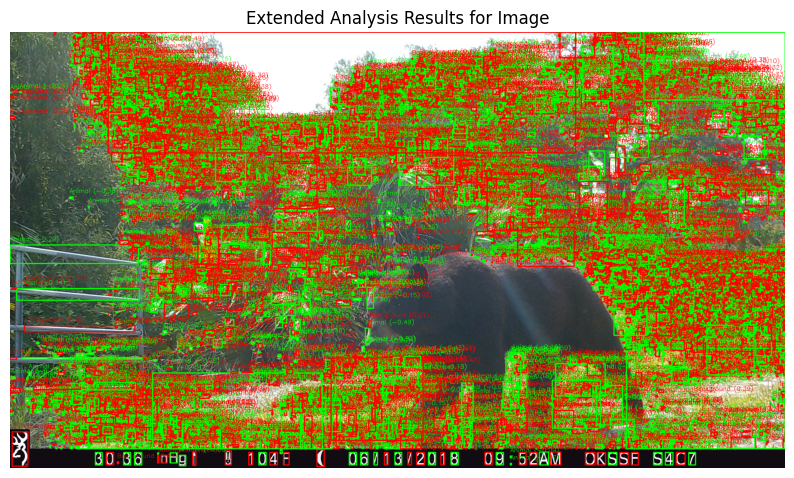

In [ ]:
def extract_patches_from_sequence(image_sequence, bounding_box, current_index):

    # Extracts patches from a sequence of images based on the given bounding box.
    x, y, w, h = bounding_box
    img = cv2.imread(image_sequence[current_index])
    patch = img[y:y+h, x:x+w]
    return [patch]

def compute_weighted_score(bbox_patch, patches, temporal_weights):
    return np.random.rand() - 0.5  # Random score between -0.5 and 0.5


# image to process
image_file = 'bears.JPG'

print(f"Processing image for extended analysis: {image_file}")

# Load and preprocess the image
img = cv2.imread(image_file)
fg_mask = compute_foreground_mask(img)
bounding_boxes = extract_candidate_bounding_boxes(fg_mask)

# Extract patches and compute scores for each bounding box
for bbox in bounding_boxes:
    x, y, w, h = bbox
    bbox_patch = img[y:y+h, x:x+w]

    # Extract patches from the frame
    patches = extract_patches_from_sequence(image_sequence=[image_file],
                                            bounding_box=bbox,
                                            current_index=0)

    # Assign temporal weights (using only one frame so all weights are equal)
    temporal_weights = [1 / (abs(0 - i) + 1) for i in range(1)]  # Only one frame, so the weight is 1
    temporal_weights = np.array(temporal_weights) / np.sum(temporal_weights)  # Normalize weights

    # Compute decision score
    score = compute_weighted_score(bbox_patch, patches, temporal_weights)


    # Classify based on score
    classification = "Animal" if score <= 0 else "Background"
    print(f"Image {image_file}, BBox {bbox}, Score: {score:.2f}, Classification: {classification}")

    # Visualize classification results
    color = (0, 255, 0) if classification == "Animal" else (0, 0, 255)
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
    label = f"{classification} ({score:.2f})"
    cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Display the results
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Extended Analysis Results for Image")
plt.axis('off')
plt.show()
